In [1]:
import os
import warnings
from tqdm.auto import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from fastai.tabular.core import df_shrink

sns.set(style="ticks", palette="muted", color_codes=True)

warnings.filterwarnings("ignore")

plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 20

seed = 42

### DATA SOURCE: https://data.ibb.gov.tr/en/dataset/hourly-traffic-density-data-set

### Merging all Traffic Density Datasets

In [2]:
def ingest_data(filename):
    # Read data
    raw_df=pd.read_csv("datasets/tr_density/tr_density_original/"+filename, parse_dates=["DATE_TIME"])
    
    # Reducing the size of the data by downcasting datatypes
    shrinked_df = df_shrink(raw_df, int2uint=True)

    return shrinked_df

In [3]:
all_df = pd.concat((ingest_data(filename=file) for file in tqdm(os.listdir("datasets/tr_density/tr_density_original"))), ignore_index=True)

  0%|          | 0/40 [00:00<?, ?it/s]

In [4]:
df=all_df.copy()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66146858 entries, 0 to 66146857
Data columns (total 8 columns):
 #   Column              Dtype         
---  ------              -----         
 0   DATE_TIME           datetime64[ns]
 1   LATITUDE            float32       
 2   LONGITUDE           float32       
 3   GEOHASH             object        
 4   MINIMUM_SPEED       uint8         
 5   MAXIMUM_SPEED       uint8         
 6   AVERAGE_SPEED       uint8         
 7   NUMBER_OF_VEHICLES  uint16        
dtypes: datetime64[ns](1), float32(2), object(1), uint16(1), uint8(3)
memory usage: 1.8+ GB


#### There are around 66 million records. The original size of the dataset was around 3.4+ GB. After downcasting the datatypes of most variables during merging, the size has been reduced to around 1.8+ GB.

### Correcting Coordinates

In [6]:
actual_long = df.loc[df['LATITUDE'].lt(39), 'LATITUDE']
actual_lat = df.loc[df['LATITUDE'].lt(39), 'LONGITUDE']

df.loc[df['LATITUDE'].lt(39), 'LONGITUDE'] = actual_long
df.loc[df['LATITUDE'].lt(39), 'LATITUDE'] = actual_lat

### Creating features from date column

In [7]:
df = df.assign(
    YEAR=df['DATE_TIME'].dt.year,
    MONTH=df['DATE_TIME'].dt.month,
    DAY=df['DATE_TIME'].dt.day,
    HOUR=df['DATE_TIME'].dt.hour,
    DAYOFWEEK=df['DATE_TIME'].dt.dayofweek
)

df[['MONTH', 'DAY', 'HOUR', 'DAYOFWEEK']]=df[['MONTH', 'DAY', 'HOUR', 'DAYOFWEEK']].astype(np.uint8)
df['YEAR']=df['YEAR'].astype(np.uint16)

In [8]:
df.head()

DATE_TIME   LATITUDE  LONGITUDE GEOHASH  MINIMUM_SPEED  MAXIMUM_SPEED   
0 2020-01-01  41.080627  28.811646  sxk3xw            135             18  \
1 2020-01-01  40.987244  29.108276  sxk9nm            143             10   
2 2020-01-01  41.003723  29.097290  sxk9q0            128              6   
3 2020-01-01  40.998230  28.679810  sxk3hx            111             22   
4 2020-01-01  41.042175  28.020630  sx7cmx             99             99   

   AVERAGE_SPEED  NUMBER_OF_VEHICLES  YEAR  MONTH  DAY  HOUR  DAYOFWEEK  
0             81                 132  2020      1    1     0          2  
1             73                 162  2020      1    1     0          2  
2             50                 110  2020      1    1     0          2  
3             68                 101  2020      1    1     0          2  
4             99                   1  2020      1    1     0          2

In [9]:
df.tail()

DATE_TIME   LATITUDE  LONGITUDE GEOHASH  MINIMUM_SPEED   
66146853 2023-04-30 23:00:00  40.965271  29.273071  sxkc41            162  \
66146854 2023-04-30 23:00:00  41.058655  28.899536  sxk99d             72   
66146855 2023-04-30 23:00:00  40.981750  29.119263  sxk9ns             45   
66146856 2023-04-30 23:00:00  41.003723  29.097290  sxk9q0            130   
66146857 2023-04-30 23:00:00  41.047668  29.108276  sxk9w2             49   

          MAXIMUM_SPEED  AVERAGE_SPEED  NUMBER_OF_VEHICLES  YEAR  MONTH  DAY   
66146853              2             59                 366  2023      4   30  \
66146854              2             32                  74  2023      4   30   
66146855              8             29                  11  2023      4   30   
66146856              3             38                 160  2023      4   30   
66146857              7             26                   6  2023      4   30   

          HOUR  DAYOFWEEK  
66146853    23          6  
66146854    23          6  
66146855    23          6  
66146856    23          6  
66146857    23          6

In [10]:
len(df['GEOHASH'].unique())

5014

#### There are total of 5014 unique locations in the dataset.

In [11]:
df.groupby('GEOHASH')['LATITUDE'].nunique().sort_values()

GEOHASH
sx5zu6    1
sxk9x5    1
sxk9x4    1
sxk9x3    1
sxk9x2    1
         ..
sxk4q9    1
sxk4q8    1
sxk4q6    1
sxk4qn    1
sxm4p3    1
Name: LATITUDE, Length: 5014, dtype: int64

In [12]:
df.groupby('GEOHASH')['LONGITUDE'].nunique().sort_values()

GEOHASH
sx5zu6    1
sxk9x5    1
sxk9x4    1
sxk9x3    1
sxk9x2    1
         ..
sxk4q9    1
sxk4q8    1
sxk4q6    1
sxk4qn    1
sxm4p3    1
Name: LONGITUDE, Length: 5014, dtype: int64

#### We have ensured all unique geohash have only a signle latitude and longitude.

## Preliminary EDA

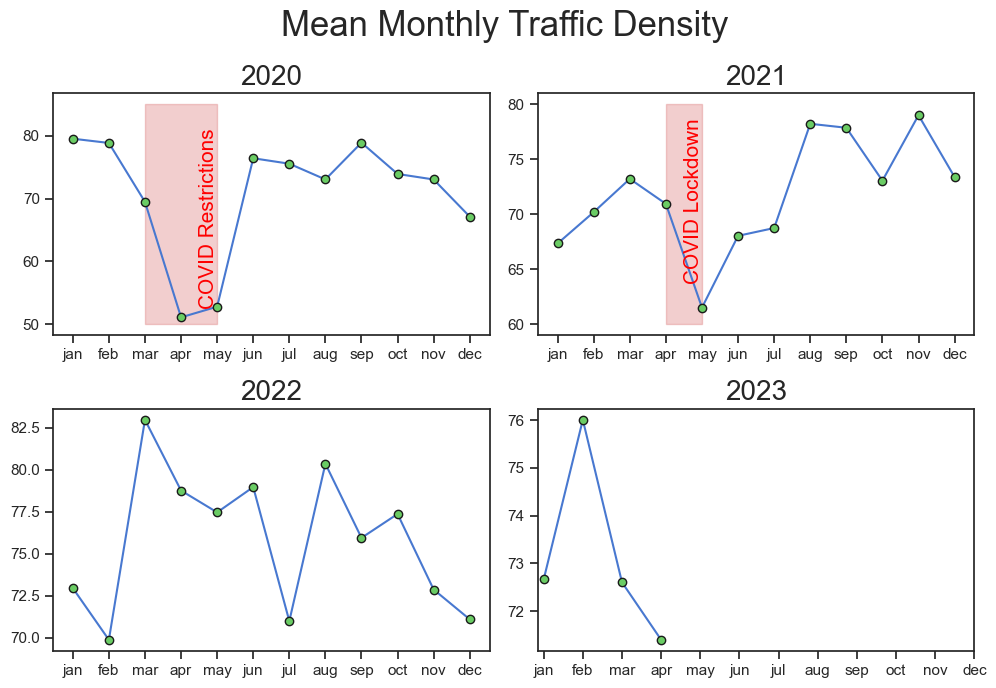

In [13]:
# Plotting Monthly Patterns
month_labels=['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

fig, axes = plt.subplots(2, 2, figsize=(10, 7), tight_layout=True)

for year, ax in zip([2020, 2021, 2022, 2023], axes.flatten()):
    (
        df.query(f"YEAR=={year}")
        .groupby('MONTH')['NUMBER_OF_VEHICLES'].mean()
        .plot(ax=ax, marker="o", mfc="g", mec="k")
    );

    ax.set_title(year)
    ax.set_xlabel("")
    
    ax.set_xticks(ticks=np.arange(1, 13, 1), labels=month_labels)

# Covid Restriction Months in 2020
axes.flatten()[0].fill_between(x=(3, 5), y1=50, y2=85, color='r', alpha = 0.3)
axes.flatten()[0].text(4.5, 53, "COVID Restrictions", fontsize=15, rotation=90, c='red')


# Covid Lockdown months in 2021
axes.flatten()[1].fill_between(x=(4, 5), y1=60, y2=80, color='r', alpha = 0.3)
axes.flatten()[1].text(4.5, 64, "COVID Lockdown", fontsize=15, rotation=90, c='red')

plt.suptitle("Mean Monthly Traffic Density", size=25);

#### The above plots illustrates monthly mean traffic density from 2020 to 2023. The shaded regions for the year 2020 represents the time periods when the Turkish government placed restrictions to prevent spread of COVID. (https://en.wikipedia.org/wiki/COVID-19_pandemic_in_Turkey). Traffic density was significantly low from March to May 2020.

#### During 2021, Turkish government announced nationwide lockdown from April 29 to May 17. The shaded region in 2021 shows a significant drop in traffic density as a result.

#### For the year 2022, the lowest traffic density is noted during February, followed by July, although the cause is not known.


#### Overall, there is no discernable monthly seasonality in traffic density. Perhaps analyzing traffic density data prior to 2020 could showcase whether there are monthly seasonality.

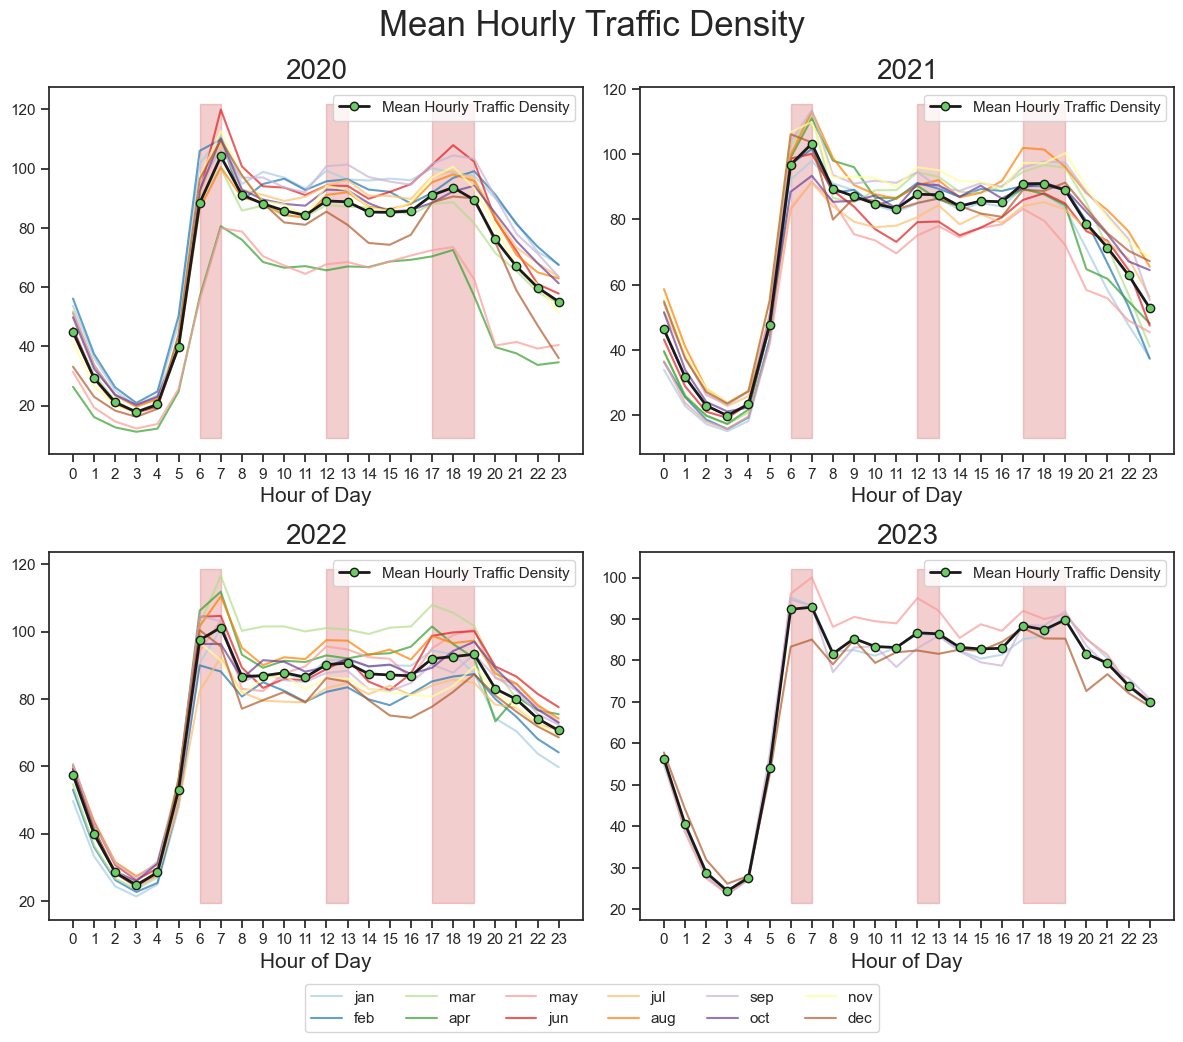

In [14]:
# Plotting Hourly Patterns
fig, axes = plt.subplots(2, 2, figsize=(12, 10), tight_layout=True)

for year, ax in zip([2020, 2021, 2022, 2023], axes.flatten()):

    # Filtering year, followed by grouping by Month and hour and taking avg traffic density. Then saving it to a temp df
    temp_df = (
        df.query(f"YEAR=={year}")
        .groupby(['MONTH', 'HOUR'])['NUMBER_OF_VEHICLES'].mean()
        .unstack('MONTH')
    )

    # Getting upper and lower y limits for shading density regions
    low_lim = temp_df.min(axis=1).min() - 2
    max_lim = temp_df.max(axis=1).max() + 2

    # Monthly Mean plots
    temp_df.plot(ax=ax, colormap='Paired', alpha=0.7)

    # Overall Mean plot
    temp_df.mean(axis=1).plot(ax=ax, c='k', lw=2, marker="o", mfc="g", mec="k", label='Mean Hourly Traffic Density')
    
    # To display on the Overall Mean plot legend
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[-1:], labels[-1:])

    ax.set_title(year)
    ax.set_xticks(ticks=np.arange(0, 24, 1))
    ax.set_xlabel("Hour of Day")
    
    # Shading Regions of peak Traffic density
    ax.fill_between(x=(6, 7), y1=max_lim, y2=low_lim, color='r', alpha = 0.3)
    ax.fill_between(x=(12, 13), y1=max_lim, y2=low_lim, color='r', alpha = 0.3)
    ax.fill_between(x=(17, 19), y1=max_lim, y2=low_lim, color='r', alpha = 0.3)

# To display Month legends
handles, _ = axes.flatten()[0].get_legend_handles_labels()
fig.legend(handles=handles, labels=month_labels, loc='lower center', ncol=6, bbox_to_anchor=(0.5, -0.05));

plt.suptitle("Mean Hourly Traffic Density", size=25);

#### The above plots depicts average hourly traffic density for all months by year. For all years and months, there are three distinct peak traffic density hours. The highest traffic density is from 6am to 7am. Then then a low traffic density peak is noticed from 12pm to 1pm. Finally, a mid-traffic density peak is observed from 5pm to 7pm.

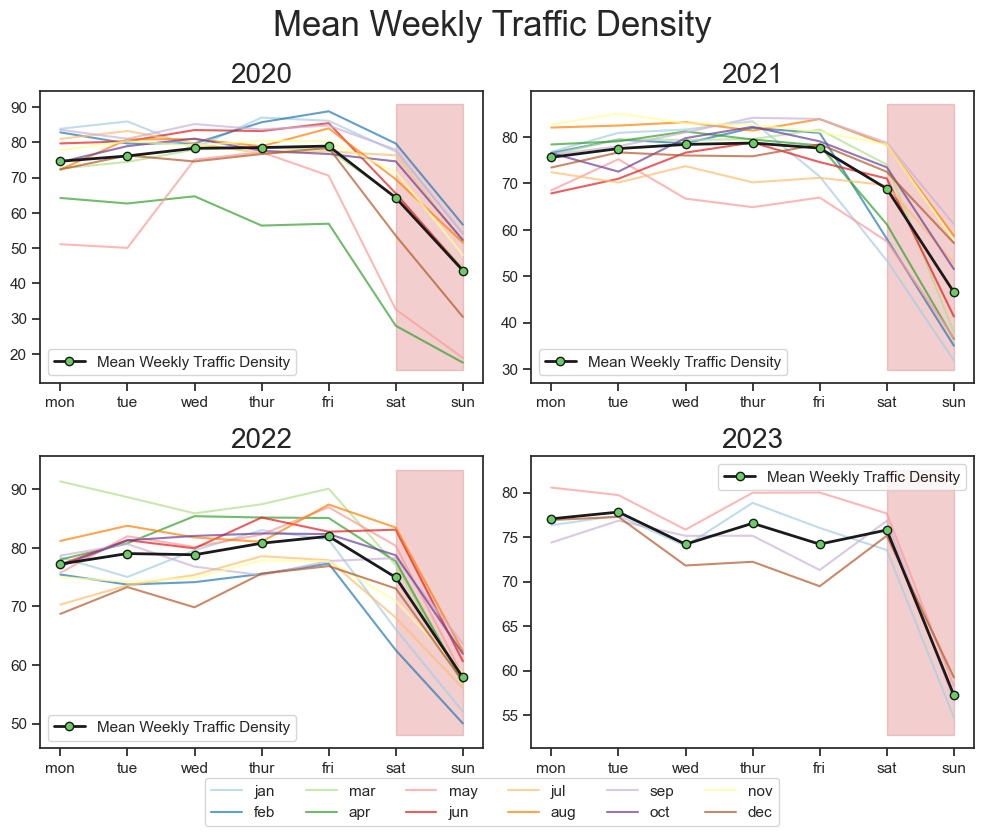

In [15]:
# Plotting Weekly Pattern
weekday_labels=["mon", "tue", "wed", "thur", "fri", "sat", "sun"]

fig, axes = plt.subplots(2, 2, figsize=(10, 8), tight_layout=True)

for year, ax in zip([2020, 2021, 2022, 2023], axes.flatten()):

    # Filtering year, followed by grouping by Month and day of week and taking avg traffic density. Then saving it to a temp df
    temp_df=(
        df.query(f"YEAR=={year}")
        .groupby(['MONTH', 'DAYOFWEEK'])['NUMBER_OF_VEHICLES'].mean()
        .unstack('MONTH')
    )

    # Getting upper and lower y limits for shading density regions
    low_lim = temp_df.min(axis=1).min() - 2
    max_lim = temp_df.max(axis=1).max() + 2

    # Monthly Mean plots
    temp_df.plot(ax=ax, colormap='Paired', alpha=0.7)

    # Overall Mean plot
    temp_df.mean(axis=1).plot(ax=ax, c='k', lw=2, marker="o", mfc="g", mec="k", label='Mean Weekly Traffic Density')
    
    # To display on the Overall Mean plot legend
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[-1:], labels[-1:])

    # Shading Regions of low Traffic Density
    ax.fill_between(x=(5, 6), y1=max_lim, y2=low_lim, color='r', alpha = 0.3)

    ax.set_title(year)
    ax.set_xticks(ticks=np.arange(0, 7, 1), labels=weekday_labels)
    ax.set_xlabel("")

# To display Month legends
handles, _ = axes.flatten()[0].get_legend_handles_labels()
fig.legend(handles=handles, labels=month_labels, loc='lower center', ncol=6, bbox_to_anchor=(0.5, -0.05))

plt.suptitle("Mean Weekly Traffic Density", size=25);

#### The above plots depicts average weekly traffic density for all months by year. Traffic density is lowest during weekends (Saturday and Sunday)

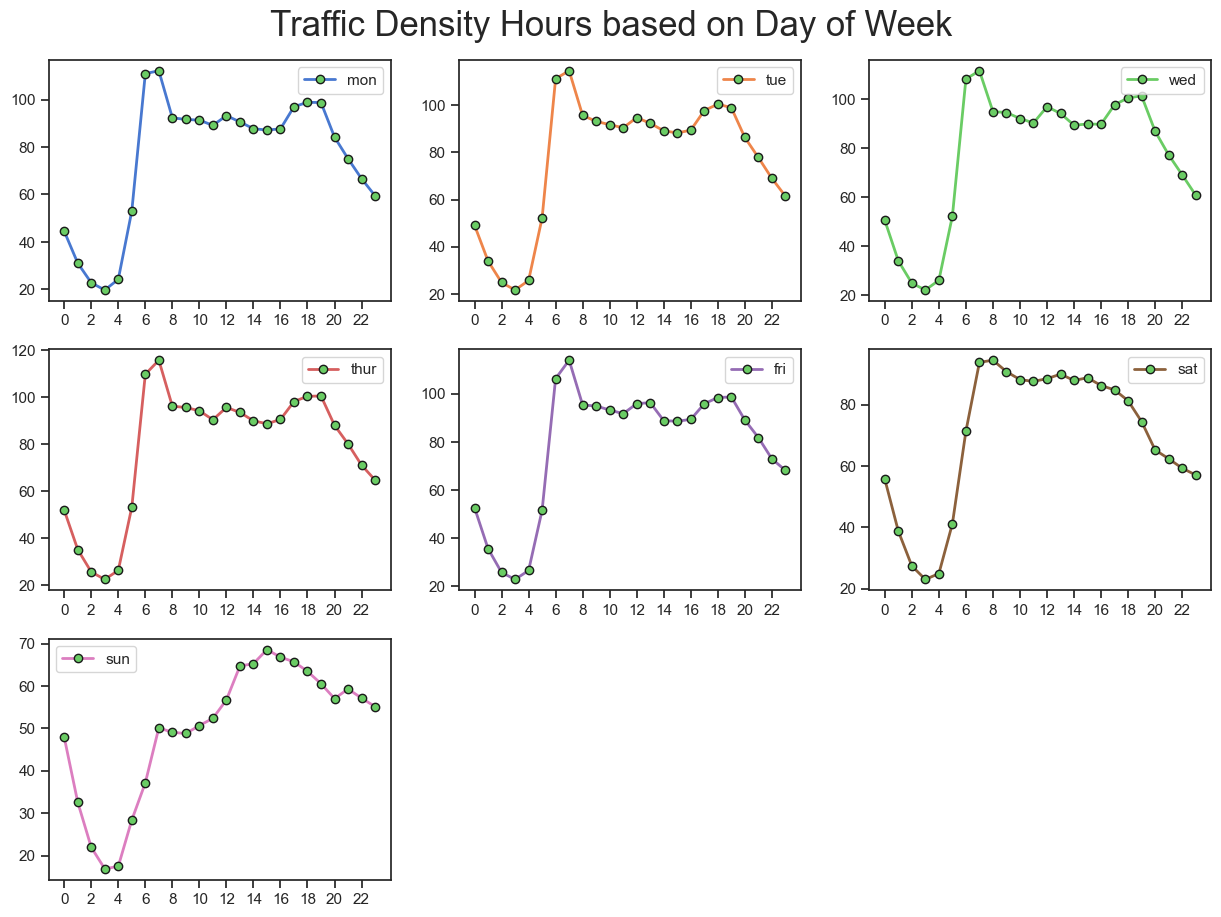

In [16]:
# Plotting Hourly pattern by day of week
axes = (
    df.groupby(['DAYOFWEEK', 'HOUR'])['NUMBER_OF_VEHICLES'].mean()
    .unstack('DAYOFWEEK')
    .plot(subplots=True, figsize=(15, 10), layout=(3, 3), sharex=False, lw=2, marker="o", mfc="g", mec="k")
)

for i, ax in enumerate(axes.flatten()[:7]):
    ax.set_xlabel("")
    ax.set_xticks(np.arange(0, 24, 2))
    handles, _ = ax.get_legend_handles_labels()
    ax.legend(handles, [weekday_labels[i]])

plt.suptitle("Traffic Density Hours based on Day of Week", fontsize=25)
plt.subplots_adjust(top=0.93);

#### The above plots depicts how traffic density for each hour in a day differs based on day of the week. From monday to Friday, the pattern is the same. But the traffic density pattern changes on weekends. Especially on sunday, the peak hours are from 12pm to 8pm.

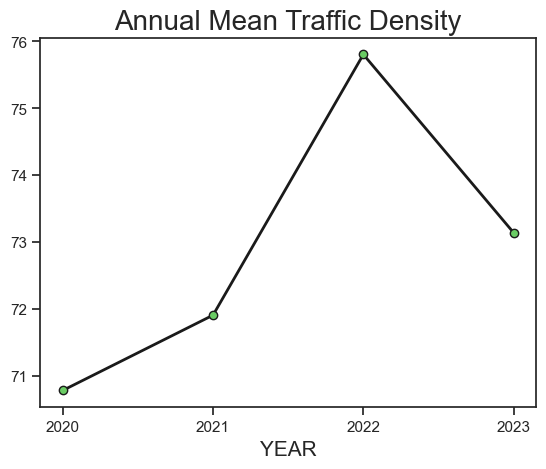

In [17]:
# Annual Pattern
ax = df.groupby('YEAR')['NUMBER_OF_VEHICLES'].mean().plot(c='k', lw=2, marker="o", mfc="g", mec="k")
ax.set_xticks([2020, 2021, 2022, 2023])
ax.set_title("Annual Mean Traffic Density");

#### The above plot illustrates annual mean traffic density. 2022 seems to have highest traffic desnity compared to 2020 and 2021. But there were certain restrictions during those years due to COVID. As mentioned earlier, perhaps traffic density from 2019 and older could help shed a more clear picture into yearly trends of traffic density.

## Do all locations (represented by 'GEOHASH') contain data for all time periods?

In [18]:
df.groupby('GEOHASH').size().sort_values()

GEOHASH
sx5zu6        1
sxk6yv        1
sxk6yz        1
sxk6z7        1
sxk6z8        1
          ...  
sxk3xe    28514
sxk3x8    28514
sxk3nk    28515
sxk3r9    28515
sxk3nt    28516
Length: 5014, dtype: int64

#### From the pandas series above, certain geohash contains only a single measurement of traffic density, which is not quite useful. It may be necessary to remove those geohash with insufficient traffic density data. This will need to be further discussed on.

In [19]:
# Creating df with unique GEOHASH and corresponding year of available data
years_by_loc = df[['GEOHASH', 'YEAR']].sort_values(['GEOHASH', 'YEAR']).drop_duplicates(ignore_index=True)

In [20]:
for yr, num_loc in zip(*np.unique(years_by_loc.groupby('GEOHASH').size().values, return_counts=True)):
    print(f'Number of locations with only {yr} year of data: {num_loc}')

Number of locations with only 1 year of data: 2542
Number of locations with only 2 year of data: 15
Number of locations with only 3 year of data: 59
Number of locations with only 4 year of data: 2398


##### The above result shows that around 2542 locations (GEOHASH) contains only for 1 year. 15 locations contains data only for 2 years, 59 locations contains data only for 3 years. Finally, 2398 locations contains data for all 4 years.

In [21]:
1216*24

29184

#### From 01 Jan 2020 to 30 April 2023, there are 1216 days. 1216 days * 24 hours gives **29184 hours** in total. Naturally we expect most locations to contain around 29,184 hours of data.

##### Next, we will see how much data points does each location contains

In [22]:
years_by_loc_cnt = years_by_loc.groupby('GEOHASH').size()

single_year_loc = years_by_loc_cnt[years_by_loc_cnt==1].index # Location containing only 1 year data
dbl_year_loc = years_by_loc_cnt[years_by_loc_cnt==2].index # Location containing only 2 year data
trpl_year_loc = years_by_loc_cnt[years_by_loc_cnt==3].index # Location containing only 3 year data
all_year_loc = years_by_loc_cnt[years_by_loc_cnt==4].index # Location containing only 4 year data

In [23]:
# Checking number of data avaialble from single year location list
(
    df.query("GEOHASH in @single_year_loc")
    .groupby('GEOHASH').size()
    .sort_values()
)

GEOHASH
sx5zu6    1
sxkb5c    1
sxkb5f    1
sxkb5q    1
sxkb5u    1
         ..
sxk47k    1
sxk47n    1
sxk47q    1
sxk47b    1
sxm4p3    1
Length: 2542, dtype: int64

In [24]:
# Checking the first GEOHASH from the above list
df.query("GEOHASH=='sx5zu6'")

DATE_TIME   LATITUDE  LONGITUDE GEOHASH  MINIMUM_SPEED   
28745700 2021-06-22 11:00:00  40.751038  27.965698  sx5zu6             21  \

          MAXIMUM_SPEED  AVERAGE_SPEED  NUMBER_OF_VEHICLES  YEAR  MONTH  DAY   
28745700             21             21                   1  2021      6   22  \

          HOUR  DAYOFWEEK  
28745700    11          1

#### All of the above locations with only a single year of data contains only 1 hour of data. These locations will have to be removed.

In [25]:
# Checking number of data avaialble from 2 years location list
(
    df.query("GEOHASH in @dbl_year_loc")
    .groupby('GEOHASH').size()
    .sort_values()
)

GEOHASH
sxkfn1        3
sx7ftv        4
sxk68f       20
sxk914       29
sxk90f      610
sxk1be      996
sxk3wq     1043
sxk3wy     1113
sxk3wm     1152
sxk3wk     1204
sx7fqh     2904
sxkde2     6187
sx7fq7     7330
sxk3zm    10426
sxk1fm    12411
dtype: int64

In [26]:
# Checking the last GEOHASH from the above list
df.query("GEOHASH=='sxk1fm'")

DATE_TIME  LATITUDE  LONGITUDE GEOHASH  MINIMUM_SPEED   
27       2020-01-01 00:00:00  41.11908   28.22937  sxk1fm             85  \
2579     2020-01-01 01:00:00  41.11908   28.22937  sxk1fm            109   
5997     2020-01-01 02:00:00  41.11908   28.22937  sxk1fm            128   
8034     2020-01-01 03:00:00  41.11908   28.22937  sxk1fm             82   
10567    2020-01-01 04:00:00  41.11908   28.22937  sxk1fm            106   
...                      ...       ...        ...     ...            ...   
28435524 2021-06-11 08:00:00  41.11908   28.22937  sxk1fm            142   
28439996 2021-06-11 09:00:00  41.11908   28.22937  sxk1fm            131   
28440693 2021-06-11 10:00:00  41.11908   28.22937  sxk1fm            135   
28442997 2021-06-11 11:00:00  41.11908   28.22937  sxk1fm             91   
28743414 2021-06-22 11:00:00  41.11908   28.22937  sxk1fm            101   

          MAXIMUM_SPEED  AVERAGE_SPEED  NUMBER_OF_VEHICLES  YEAR  MONTH  DAY   
27                   69             79                   5  2020      1    1  \
2579                 84             97                   4  2020      1    1   
5997                 50             71                   6  2020      1    1   
8034                 82             82                   1  2020      1    1   
10567               106            106                   1  2020      1    1   
...                 ...            ...                 ...   ...    ...  ...   
28435524             55             98                  25  2021      6   11   
28439996             67             92                  27  2021      6   11   
28440693             48             90                  25  2021      6   11   
28442997             74             82                   6  2021      6   11   
28743414             64             82                  16  2021      6   22   

          HOUR  DAYOFWEEK  
27           0          2  
2579         1          2  
5997         2          2  
8034         3          2  
10567        4          2  
...        ...        ...  
28435524     8          4  
28439996     9          4  
28440693    10          4  
28442997    11          4  
28743414    11          1  

[12411 rows x 13 columns]

#### The above list shows locations with only 2 years of data. And none of these locations contains close to 29k hours of data. 

In [27]:
# Checking number of data avaialble from 3 year location list
(
    df.query("GEOHASH in @trpl_year_loc")
    .groupby('GEOHASH').size()
    .sort_values()
)

GEOHASH
sxm41j        8
sxkbhq       20
sxk1w8       24
sxkbfr      260
sxk604      348
sxkd19      433
sxkb6v      447
sxk8y9      499
sxk3tr      685
sxk3tq     1844
sxk3tm     2902
sxk3tk     3033
sxk3t7     3068
sxkbvp     3272
sxkb6r     7125
sxkbvr    12274
sxkbuz    12382
sxkb5n    12454
sxkbv6    12972
sxkc00    13271
sxkc1r    13372
sxkbed    14608
sxk9cf    14983
sxkbvk    14985
sxkbvh    15370
sxkb7h    15410
sxkbvn    15414
sxkbvj    15468
sxkbez    15565
sxk94x    15637
sxkbuy    15687
sxkb7z    15707
sxkb5p    15772
sxk9ry    15862
sxkbe3    15951
sxkbey    15961
sxkb6j    15962
sxkb5r    15963
sxkbsq    15968
sxkbew    15972
sxkbev    15993
sxkb72    15999
sxkbex    16004
sxkb7n    16013
sxkb7r    16014
sxkbe8    16015
sxkc1p    16015
sxkb6w    16015
sxkbsh    16019
sxkb7x    16020
sxkbef    16021
sxkb7j    16022
sxkbeg    16022
sxkb9g    16024
sxkbe9    16024
sxkbeu    16024
sxkb7q    16025
sxkbe2    16026
sxkb6e    16026
dtype: int64

#### Same as before, none of these locations containing 3 years of data have anywhere close to 29k hours of data.

In [28]:
# Checking number of data avaialble from 4 year location list
(
    df.query("GEOHASH in @all_year_loc")
    .groupby('GEOHASH').size()
    .sort_values()
)

GEOHASH
sxk97b       10
sx7fv9       25
sxk67j       35
sxk9xf       45
sxk6q6       62
          ...  
sxk3py    28514
sxk3xe    28514
sxk3r9    28515
sxk3nk    28515
sxk3nt    28516
Length: 2398, dtype: int64

In [29]:
# Checking first location from the above list
df.query("GEOHASH=='sxk97b'")

DATE_TIME   LATITUDE  LONGITUDE GEOHASH  MINIMUM_SPEED   
13385815 2020-09-06 16:00:00  41.003723  28.998413  sxk97b             10  \
16238026 2020-10-28 09:00:00  41.003723  28.998413  sxk97b             11   
16814884 2020-11-08 15:00:00  41.003723  28.998413  sxk97b              9   
18584833 2020-12-11 01:00:00  41.003723  28.998413  sxk97b             11   
25948805 2021-04-26 14:00:00  41.003723  28.998413  sxk97b              9   
28743924 2021-06-22 11:00:00  41.003723  28.998413  sxk97b             25   
31997187 2021-08-19 14:00:00  41.003723  28.998413  sxk97b             22   
41764810 2022-02-11 07:00:00  41.003723  28.998413  sxk97b             21   
52545645 2022-08-28 10:00:00  41.003723  28.998413  sxk97b              5   
63076312 2023-03-04 21:00:00  41.003723  28.998413  sxk97b             70   

          MAXIMUM_SPEED  AVERAGE_SPEED  NUMBER_OF_VEHICLES  YEAR  MONTH  DAY   
13385815              8              9                   1  2020      9    6  \
16238026             11             11                   1  2020     10   28   
16814884              8              8                   1  2020     11    8   
18584833             10             10                   1  2020     12   11   
25948805              8              8                   1  2021      4   26   
28743924             20             23                   5  2021      6   22   
31997187             22             22                   1  2021      8   19   
41764810             21             21                   1  2022      2   11   
52545645              4              4                   1  2022      8   28   
63076312             70             70                   1  2023      3    4   

          HOUR  DAYOFWEEK  
13385815    16          6  
16238026     9          2  
16814884    15          6  
18584833     1          4  
25948805    14          0  
28743924    11          1  
31997187    14          3  
41764810     7          4  
52545645    10          6  
63076312    21          5

#### The above list of locations contains data for all 4 years. But even still, many of these locations do not have sufficient hours of data.

# QUESTIONS:

* Which locations with insufficient data to be removed?
* How to address missing hours of data?
* For future tasks, do we forcast data on hourly basis or daily basis?
* Is there data avaialble prior to 2020? If so, are the data prior to 2020 in the same format as the curent data? Do we have data for the same locations?

In [30]:
# df.to_parquet("ist_traffic_density_rev01.gz", compression='gzip')

In [37]:
loc_hrly_data=df.groupby(["GEOHASH", "LATITUDE", "LONGITUDE"], as_index=False).size()

In [67]:
# Plotting GEOHASH locations
import folium
import branca.colormap as cm

colors = ['green', 'darkred']
colormap = cm.LinearColormap(colors=colors, vmin=1, vmax=29000)

map = folium.Map(location=[loc_hrly_data['LATITUDE'].mean(), loc_hrly_data['LONGITUDE'].mean()], zoom_start=9)

for index, row in loc_hrly_data.iterrows():
    folium.CircleMarker([row['LATITUDE'], row['LONGITUDE']], 
                        radius=3,
                        color='black',  # Set the edge color to black
                        weight=0.7,  # Adjust the weight of the edge
                        fill=True,
                        fill_color=colormap(row['size']),  # Set the interior color
                        popup=row['GEOHASH']).add_to(map)

map